#### Add project directory to working path

In [1]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])
utilities_dir = str(curr_dir.parent)

if utilities_dir not in sys.path:
    sys.path.append(utilities_dir)

#### Import useful packages

In [2]:
import csv
import pandas as pd
import utilities.utils as u
import pmutils as pmu

from utilities.signal.signal import Signal
from metadata import QhPmMetadata as qh, RbMetadata as rb

# Choose magnet type and day to analyse

In [4]:
dayTimeStamp = '2015-03-13 00:00:00.000'
magnetTypes = ['MB']

# Get events for a single day - comparison with the Java PM Browser
<img src = "figures/JavaPMBrowser.png" width=50%>

In [5]:
eventDurationSeconds = 24*60*60 # 1 day in seconds (max duration allowed in request)

dayTimeStampInNanos = u.timestamp2unixtimeInNanoSecond(pd.Timestamp(dayTimeStamp, tz='Europe/Zurich'))
magnetTypeToSignalMetadata = qh.getMetadata(magnetTypes)
eventSourceAndTimestamp = []
for magnetType, signalMetadata in magnetTypeToSignalMetadata.items(): # for all requested magnet types
    eventSourceAndTimestamp += pmu.findPmEvents(dayTimeStampInNanos, eventDurationSeconds,\
                                           qh.source, qh.system, signalMetadata['className'], magnetType)

# Display number of events for a single day

In [7]:
print("Total events on {}: {}".format(dayTimeStamp, len(eventSourceAndTimestamp)))

Total events on 2015-03-13 00:00:00.000: 25


# Display event source and timestamp of a single day

In [8]:
for magnetType, event, timestamp in eventSourceAndTimestamp:
    print('Analysing quench heater firing of {} on {}, {}'\
          .format(event, u.unixTimeInNanoSecond2datatime(timestamp), timestamp))

Analysing quench heater firing of B20L5 on 2015-03-13 05:21:09.21, 1426220469491000000
Analysing quench heater firing of C20L5 on 2015-03-13 05:21:57.21, 1426220517100000000
Analysing quench heater firing of A20L5 on 2015-03-13 05:21:58.21, 1426220518112000000
Analysing quench heater firing of A21L5 on 2015-03-13 05:23:45.23, 1426220625990000000
Analysing quench heater firing of B21L5 on 2015-03-13 05:27:46.27, 1426220866112000000
Analysing quench heater firing of C23L4 on 2015-03-13 09:53:22.53, 1426236802332000000
Analysing quench heater firing of B23L4 on 2015-03-13 09:53:59.53, 1426236839404000000
Analysing quench heater firing of A23L4 on 2015-03-13 09:53:59.53, 1426236839832000000
Analysing quench heater firing of C22L4 on 2015-03-13 09:55:49.55, 1426236949841000000
Analysing quench heater firing of C15R4 on 2015-03-13 13:54:45.54, 1426251285711000000
Analysing quench heater firing of B15R4 on 2015-03-13 13:55:37.55, 1426251337747000000
Analysing quench heater firing of A15R4 on 

# Choose an event to be analysed

In [9]:
eventIndex = 0
magnetType, magnet, timestamp = eventSourceAndTimestamp[eventIndex]
metadata = qh.getMetadata([magnetType])[magnetType]

# Process single event of a single day - get raw data
- get all voltages
- get all currents

Assumptions: A single event is always for a single magnet type and a single magnet name

Inputs: subDictionary for one magnet type, system, className, source, magnetName, eventTimeStamp

Output: DF

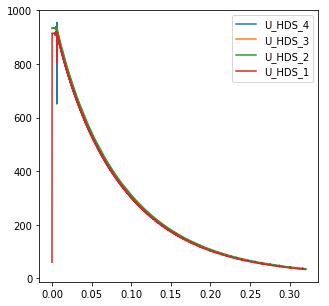

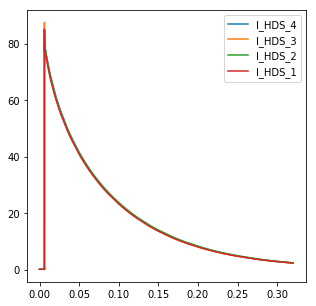

In [11]:
system = qh.system
className = metadata['className']
uNames = metadata['uNames']
iNames = metadata['iNames']
frameName = 'QH_Discharge_' + metadata['sourcePrefix'] + magnet

QhDischarge = Signal.getPmSignals(frameName, uNames+iNames, system, className, magnet, timestamp)
myDF = QhDischarge.getSynchronizedDF()
myDF.filter(regex=("U_HDS_\d{1}")).plot(figsize=(5,5))
myDF.filter(regex=("I_HDS_\d{1}")).plot(figsize=(5,5))

# Compare raw data from REST API to Java PM Browser
<img src = "figures/JavaPMBrowserVoltage.png" width=50%>
<img src = "figures/JavaPMBrowserCurrent.png" width=50%>

# Process single event of a single day - filter signals
- filter all signals

In [12]:
Signal.filterSignalNames(QhDischarge.df, metadata['filterNames'])

# Process single event of a single day - calculate features as a table
- calculate features: min value, max value, mean value, std value, start value, end value

In [13]:
featureDF = Signal.getFeatureDataFrame(QhDischarge.df)
featureDF

I_HDS_4    I_HDS_3    I_HDS_2    I_HDS_1     U_HDS_4     U_HDS_3  \
max    82.849820  87.547750  84.825890  85.140610  955.216800  919.682900   
min     0.083926   0.055315   0.026704   0.051500   34.671387   33.751415   
avg    31.300230  30.796603  30.949465  30.723855  461.635981  452.295844   
std    24.256852  23.911562  23.997942  23.831516  305.185307  299.036812   
start   0.089648   0.091555   0.087740   0.085833  934.306640  914.009770   
end     2.328935   2.300324   2.382343   2.279343   34.671387   33.751415   

          U_HDS_2     U_HDS_1  
max    938.465640  918.034670  
min     35.725517   33.291430  
avg    465.669847  451.618810  
std    305.374864  299.028675  
start  933.616640   60.047237  
end     35.725517   33.291430

# Process single event of a single day - calculate features as a row
- calculate features: min value, max value, mean value, std value, start value, end value

In [14]:
rowFeatureDF = Signal.getFeatureRowDataFrame(QhDischarge.df, timestamp)
print(rowFeatureDF)

                     I_HDS_4_max  I_HDS_3_max  I_HDS_2_max  I_HDS_1_max  \
timestamp                                                                 
1426220469491000000     82.84982     87.54775     84.82589     85.14061   

                     U_HDS_4_max  U_HDS_3_max  U_HDS_2_max  U_HDS_1_max  \
timestamp                                                                 
1426220469491000000     955.2168     919.6829    938.46564    918.03467   

                     I_HDS_4_min  I_HDS_3_min     ...       U_HDS_2_0  \
timestamp                                         ...                   
1426220469491000000     82.84982     87.54775     ...       933.61664   

                     U_HDS_1_0  I_HDS_4_end  I_HDS_3_end  I_HDS_2_end  \
timestamp                                                               
1426220469491000000  60.047237     2.328935     2.300324     2.382343   

                     I_HDS_1_end  U_HDS_4_end  U_HDS_3_end  U_HDS_2_end  \
timestamp                        

# Get operating current from PM/CALS
- for a given magnet name get the sector number
- query from CALS the operating current at the moment of an event
- get beam mode at the moment of an event

Querying CALS: RPTE.UA47.RB.A45:I_MEAS from 2015-03-13 05:20:59.20 to 2015-03-13 05:21:19.21


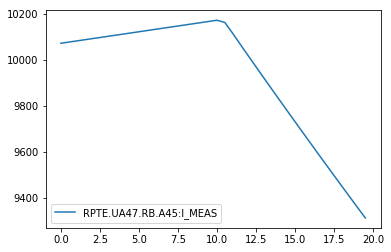

In [15]:
arcName = rb.getArcNameFromMagnetName(magnet)
arcMetadata = rb.getMetadata([arcName])
arcCurrentName = arcMetadata[arcName]['signalFGC_ABS']

eventDurationInSeconds = 10e9
t1 = u.unixTimeInNanoSecond2datatime(timestamp - eventDurationInSeconds)
t2 = u.unixTimeInNanoSecond2datatime(timestamp + eventDurationInSeconds)

print("Querying CALS: {} from {} to {}".format(arcCurrentName, t1, t2))

signal = Signal()
signal.read('cals', True, name=arcCurrentName, startTime=t1, endTime=t2)
arcCurrent = signal.getSynchronizedDF()
arcCurrent.plot()

# Add max current to the dataframe

In [16]:
maxArcCurrent = arcCurrent.max()
print("Operating current at the moment of the event: {}".format(maxArcCurrent[0]))
rowFeatureDF[arcCurrentName] = maxArcCurrent[0]

print(rowFeatureDF)

Operating current at the moment of the event: 10171.5
                     I_HDS_4_max  I_HDS_3_max  I_HDS_2_max  I_HDS_1_max  \
timestamp                                                                 
1426220469491000000     82.84982     87.54775     84.82589     85.14061   

                     U_HDS_4_max  U_HDS_3_max  U_HDS_2_max  U_HDS_1_max  \
timestamp                                                                 
1426220469491000000     955.2168     919.6829    938.46564    918.03467   

                     I_HDS_4_min  I_HDS_3_min           ...             \
timestamp                                               ...              
1426220469491000000     82.84982     87.54775           ...              

                     U_HDS_1_0  I_HDS_4_end  I_HDS_3_end  I_HDS_2_end  \
timestamp                                                               
1426220469491000000  60.047237     2.328935     2.300324     2.382343   

                     I_HDS_1_end  U_HDS_4_end  U_HD

# For a regular QH discharge calculate
- time constant for voltage (from exponential signal squared and logarithm)
- time constant for current (MB)

Consider an exponential decay with a known initial value $f_0$ and time constant $\tau$
\begin{equation}
f(t) = f_0 e^{-t/\tau}.
\end{equation}

The square of the exponential function $f(t)$ reads
\begin{equation}
f^2(t) = f_0^2 e^{-2t/\tau}.
\end{equation}

The time integral of $f^2(t)$ for $t \in [t_0, t_1]$ is given as
\begin{equation}
    \int_{\theta_0}^{\theta_1} f^2(t) d\theta = 
    \int_{\theta_0}^{\theta_1} f_0^2 e^{-2t/\tau} d\theta = 
    -\frac{\tau}{2}f_0^2e^{-2t/\tau}\Big|_{\theta_0}^{\theta_1} =
    -\frac{\tau}{2}f_0^2e^{-2\theta_1/\tau} - \left(-\frac{\tau}{2}f_0^2e^{-2\theta_0/\tau}\right)
\end{equation}

We find that $\frac{\tau}{2}f_0^2e^{-2t_1/\tau} = f^2(t_1)$ and analogously $\frac{\tau}{2}f_0^2e^{-2t_0/\tau} = f^2(t_0)$.As a result, the square of an exponent can be written as
\begin{equation}
    \int_{\theta_0}^{\theta_1} f^2(t) d\theta = \frac{\tau}{2}(f^2(t_0)-f^2(t_1)).
\end{equation}

To conclude, knowing the profile of an exponential decay $f(t)$ for $t \in [t_0, t_1]$ and assuming that the time constant does not change, i.e., $\partial_t \tau = 0$, the time constant is calculated as
\begin{equation}
    \tau = 2 \frac{\int_{\theta_0}^{\theta_1} f^2(t) d\theta}{f^2(t_0)-f^2(t_1)}.
\end{equation}

Thus, from an exponential decay of the voltage in a QH capacitor bank, i.e., $u(t) = U_0 e^{-t/\tau}$, where $\tau = RC$ with resistance $R$ and capacitance $C$, the time constant can be immediately calculated.


Following the same reasoning, it can be also applied to calculate the time constant from the RC current discharge
\begin{equation}
    i(t) = C\partial_t{u(t)} = -\frac{CU_0}{\tau}e^{-t/\tau} = 
    -\frac{CU_0}{RC}e^{-t/\tau} = - \frac{U_0}{R}e^{-t/\tau} = 
    -I_0 e^{-t/\tau}.
\end{equation}

## Calculate time constant for voltage

Decay time constant = 94.7 ms


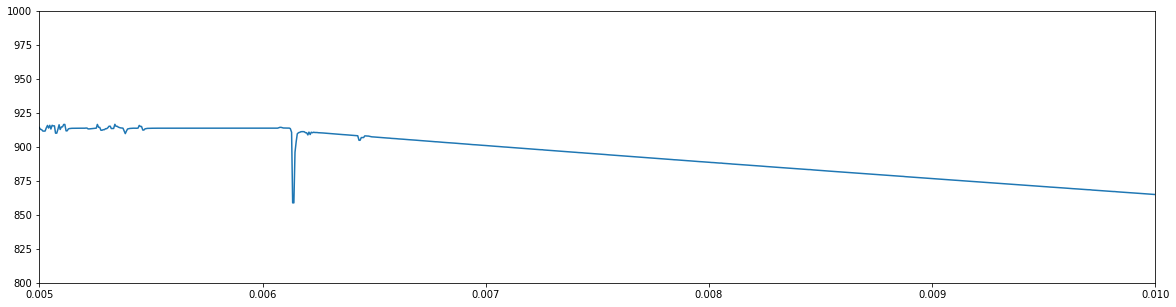

In [17]:
signalHDS = "U_HDS_1"
myDF = QhDischarge.getSynchronizedDF()[signalHDS]

decayTimeConstantVoltage = pmu.getDecayTimeConstant(myDF, timeUnitMultiplier=1000)

print("Decay time constant = %.1f ms" % decayTimeConstantVoltage)

myDFSliced = pmu.getWindowWithGivenMeanAndStd(myDF)  
myDF.plot(xlim=(0.005,0.01), ylim=(800,1000), figsize=(20,5))
# myDFSliced.plot(xlim=(0.005,0.01), ylim=(800,1000), figsize=(20,5))

## Add voltage-based time constant to dataframe

In [18]:
rowFeatureDF["tau_" + signalHDS] = decayTimeConstantVoltage

### Time constant for current

Decay time constant = 69.8 ms


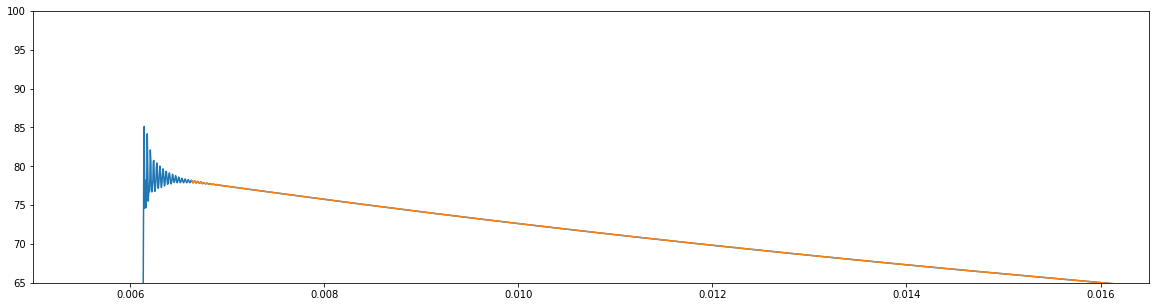

In [19]:
signalHDS = "I_HDS_1"
myDF = QhDischarge.getSynchronizedDF()[signalHDS]

decayTimeConstantCurrent = pmu.getDecayTimeConstant(myDF, timeUnitMultiplier=1000)

print("Decay time constant = %.1f ms" % decayTimeConstantCurrent)

myDFSliced = pmu.getWindowWithGivenMeanAndStd(myDF)  
myDF.plot(xlim=(0.005,0.0165), ylim=(65,100), figsize=(20,5))
myDFSliced.plot(xlim=(0.005,0.0165), ylim=(65,100), figsize=(20,5))

# Add current-based time constant to dataframe

In [20]:
rowFeatureDF["tau_" + signalHDS] = decayTimeConstantCurrent

# For a regular QH discharge calculate
- calculate resistance (MB)
- calculate derivative of resistance (MB)

In [21]:
rNames = metadata['rNames']
dRNames = metadata['dRNames']
Signal.calculateResistances(QhDischarge.df, uNames, iNames, rNames)
Signal.filterResistancesForCurrentBelowThreshold(QhDischarge.df, iNames, rNames)
Signal.calculateTimeDerivativeOfSignals(QhDischarge.df, QhDischarge.getSynchronizedTime(), rNames, dRNames)

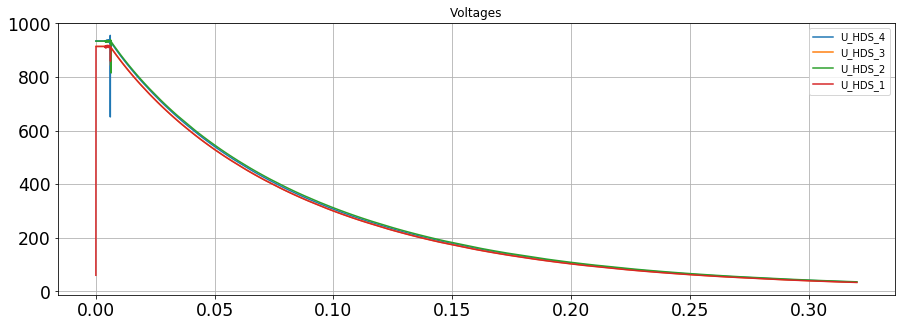

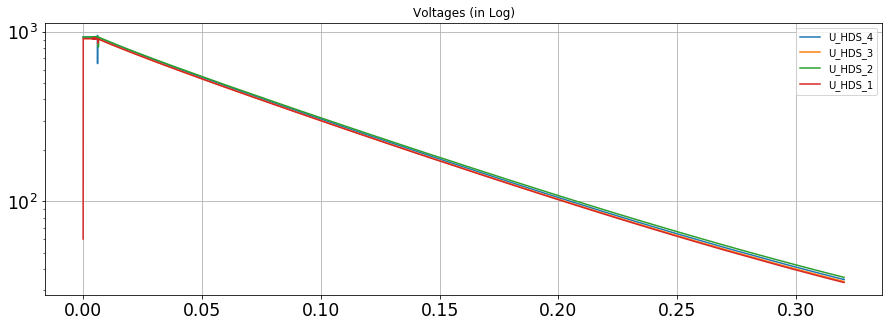

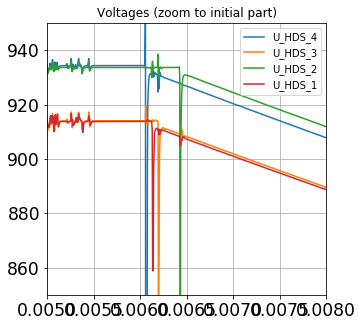

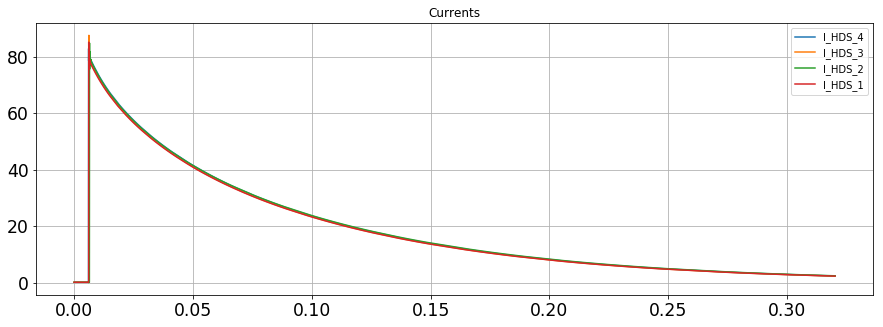

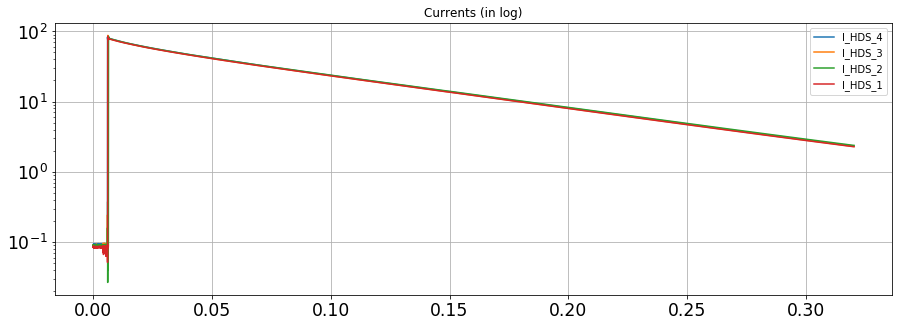

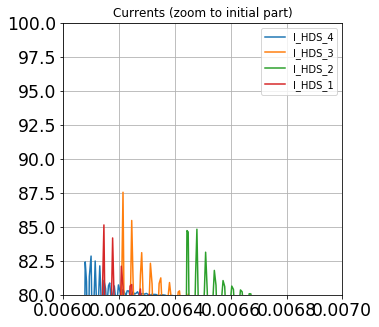

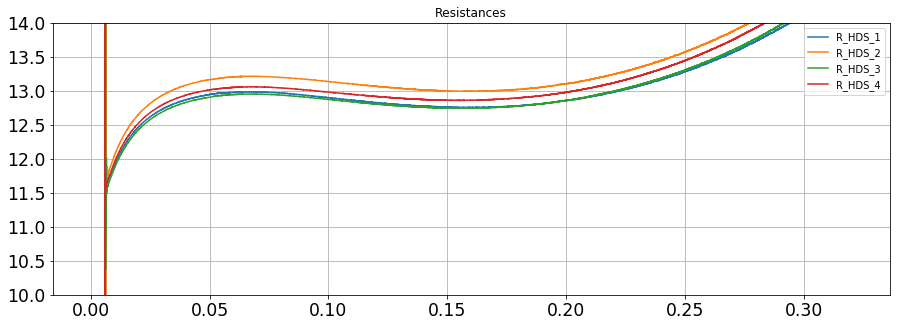

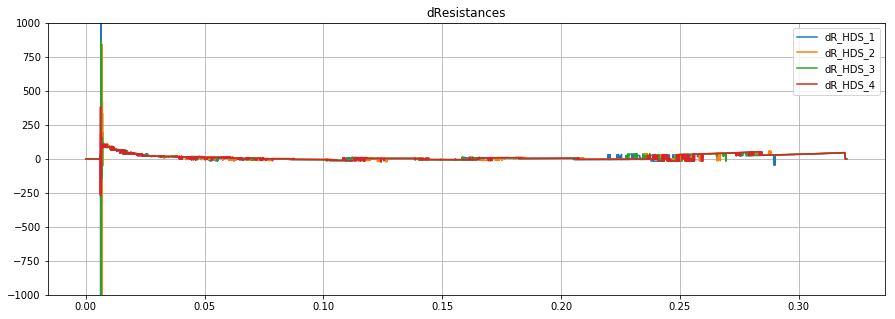

In [22]:
myDF = QhDischarge.getSynchronizedDF()
myDF.filter(regex=("U_HDS_\d{1}")).plot(title='Voltages', x=None, logy=False, figsize=(15,5), grid=True, fontsize="xx-large")
myDF.filter(regex=("U_HDS_\d{1}")).plot(title='Voltages (in Log)', x=None, logy=True, figsize=(15,5), grid=True, fontsize="xx-large")
myDF.filter(regex=("U_HDS_\d{1}")).plot(title='Voltages (zoom to initial part)', x=None, logy=False, figsize=(5, 5), xlim=(0.005,0.008), ylim=(850,950), grid=True, fontsize="xx-large")
myDF.filter(regex=("I_HDS_\d{1}")).plot(title='Currents', x=None, logy=False, figsize=(15,5), grid=True, fontsize="xx-large")
myDF.filter(regex=("I_HDS_\d{1}")).plot(title='Currents (in log)', x=None, logy=True, figsize=(15,5), grid=True,fontsize="xx-large")
myDF.filter(regex=("I_HDS_\d{1}")).plot(title='Currents (zoom to initial part)', x=None, logy=False, figsize=(5,5), xlim=(0.006,0.007), ylim=(80,100), grid=True, fontsize="xx-large")
myDF.filter(regex=("^R_HDS_\d{1}")).plot(title='Resistances', x=None, logy=False, ylim=(10,14), figsize=(15,5), grid=True, fontsize="xx-large")
myDF.filter(regex=("dR_HDS_\d{1}")).plot(title='dResistances', x=None, logy=False, figsize=(15,5), ylim=(-1000,1000), grid=True)

# Write to InfluxDB
QhDischarge already contain the measurement name

In [23]:
QhDischarge.write('influx')

/cvmfs/sft.cern.ch/lcg/views/LCG_94python3/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


# Write final dataframe to a csv file

In [20]:
fileName = 'output/{}/{}_single_event_single_day.csv'.format(magnetTypes[0], magnetTypes[0])

rowFeatureDF.to_csv(fileName)

with open(fileName,'w') as out:
    rowFeatureDF.to_csv(out, header=True)
out.close()